In [ ]:
# u prime check changing sign

In [1]:
import os

In [2]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

In [3]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [4]:
%matplotlib inline

In [36]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25  ) #24    # fontsize of the x and y labels

In [6]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_wthmp


In [7]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
start_time='1950-01-31 00:00:00'
end_time='1959-12-31 00:00:00'


In [38]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '03:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/36267/status,
Dashboard: /proxy/36267/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.27:36273,Workers: 0
Dashboard: /proxy/36267/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-827848' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


In [9]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s#.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s#.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})


In [39]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')

In [10]:
%%time
## coarsen monthly because no daily eke
u_reshape_arr = []
for xx in range(0,6):
    u_chunk = u.isel(xu_ocean = slice(xx*600,600*(xx+1))).chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
    u_reshape_elem = u_chunk.coarsen(time=12).construct(time=('year', 'month')).mean('year').load()
    u_reshape_arr.append(u_reshape_elem)

CPU times: user 7.32 s, sys: 1.06 s, total: 8.37 s
Wall time: 48.6 s


In [11]:
u_reshape = xr.merge(u_reshape_arr)

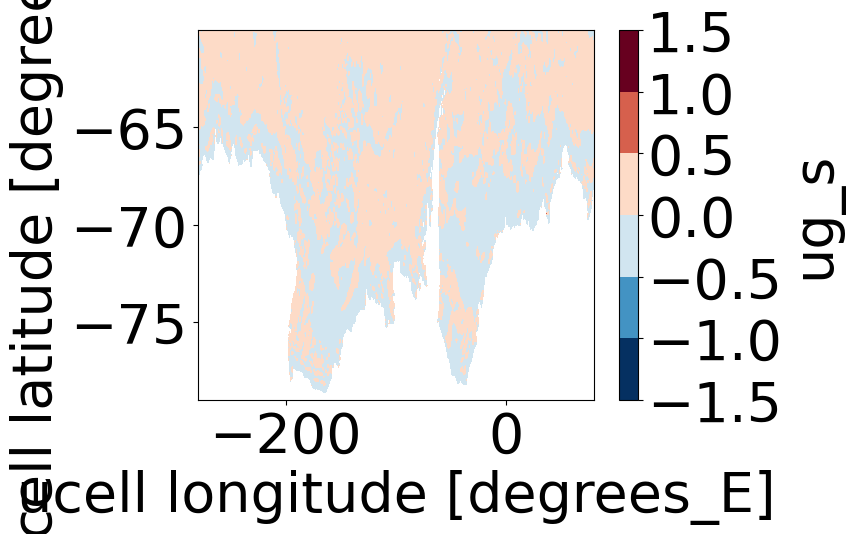

In [12]:
u_reshape.isel(month = 0).ug_s.plot.contourf()

In [13]:
%%time

v_reshape_arr = []
for xx in range(0,6):
    v_chunk = v.isel(xu_ocean = slice(xx*600,600*(xx+1))).chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
    v_reshape_elem = v_chunk.coarsen(time=12).construct(time=('year', 'month')).mean('year').load()
    v_reshape_arr.append(v_reshape_elem)

CPU times: user 5.79 s, sys: 680 ms, total: 6.47 s
Wall time: 27 s


In [14]:
v_reshape = xr.merge(v_reshape_arr)

In [15]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [16]:
flex_period = slice(start_time_mw,end_time_mw)
flex_period = slice('2110','2159')

In [17]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [18]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [19]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

In [20]:
vel = xr.merge([coordinates, u.sel(time=flex_period), v.sel(time=flex_period), ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [21]:
vel

<xarray.Dataset> Size: 15GB
Dimensions:     (xt_ocean: 3600, yt_ocean: 440, xu_ocean: 3600, yu_ocean: 440,
                 time: 600)
Coordinates:
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.1 -60.05
    geolon_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * time        (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables: (12/13)
    dxt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    ug_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    vg_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    ...          ...
    hu          (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    drag_coeff  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...

In [22]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [23]:
grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [24]:
import gc

In [25]:
u

<xarray.DataArray 'ug_s' (yu_ocean: 440, xu_ocean: 3600, time: 600)> Size: 8GB
dask.array<open_dataset-ug_s, shape=(440, 3600, 600), dtype=float64, chunksize=(440, 3600, 600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    long_name:      $u_g,s$
    units:          $\mathrm{ms}^{-1}$

In [ ]:
## calculating transients

In [72]:
%%time
u_transient_int = []
v_transient_int = []
for tt in np.arange(0,50,10):
    u_transient = []
    v_transient = []

    for xx in range(12): # up to 12
        c.run(gc.collect)
        u_transient_clim = (u.isel(xu_ocean = slice(xx*300, (xx+1)*300), time = slice(tt*12,(tt+1)*12)).groupby( 'time.month') - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300)))
        v_transient_clim = (v.isel(xu_ocean = slice(xx*300, (xx+1)*300), time = slice(tt*12,(tt+1)*12)).groupby( 'time.month') - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300)))
        u_transient.append(u_transient_clim.load())
        v_transient.append(v_transient_clim.load())
        #del u_transient_clim, v_transient_clim
        print(xx)
    u_transient_arr = xr.merge(u_transient).ug_s.where(cluster_mask_access== True)
    v_transient_arr = xr.merge(v_transient).vg_s.where(cluster_mask_access== True)
    print(u_transient_arr)
    #del u_transient, v_transient
    
    u_transient_clim_int = grid.integrate(u_transient_arr, axis = {'X','Y'}).load()
    v_transient_clim_int = grid.integrate(v_transient_arr, axis = {'X','Y'}).load()
    del u_transient_arr, v_transient_arr

    u_transient_int.append(u_transient_clim_int)
    v_transient_int.append(v_transient_clim_int)
    del u_transient_clim_int, v_transient_clim_int

    print('tt = ' + str(tt))

0
1
2
3
4
5
6
7
8
9
10
11
<xarray.Dataset> Size: 165MB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600, time: 12)
Coordinates:
  * xu_ocean                       (xu_ocean) float64 29kB -279.9 ... 80.0
  * yu_ocean                       (yu_ocean) float64 4kB -78.98 ... -60.02
  * time                           (time) object 96B 2110-01-16 12:00:00 ... ...
    geolon_c                       (yu_ocean, xu_ocean) float32 6MB nan ... 80.0
    geolat_c                       (yu_ocean, xu_ocean) float32 6MB nan ... -...
    month                          (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    __xarray_dataarray_variable__  (yu_ocean, xu_ocean, time) float64 152MB dask.array<chunksize=(440, 3600, 12), meta=np.ndarray>
tt = 0
0
1
2
3
4
5
6
7
8
9
10
11
<xarray.Dataset> Size: 165MB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600, time: 12)
Coordinates:
  * xu_ocean                       (xu_ocean) float64 29kB -279.9 ... 80.0
  * yu_o

In [73]:
u_transient_int

[<xarray.Dataset> Size: 288B
 Dimensions:                        (time: 12)
 Coordinates:
   * time                           (time) object 96B 2110-01-16 12:00:00 ... ...
     month                          (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
 Data variables:
     __xarray_dataarray_variable__  (time) float64 96B 5.613e+10 ... 5.618e+10,
 <xarray.Dataset> Size: 288B
 Dimensions:                        (time: 12)
 Coordinates:
   * time                           (time) object 96B 2120-01-16 12:00:00 ... ...
     month                          (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
 Data variables:
     __xarray_dataarray_variable__  (time) float64 96B 3.432e+10 ... 3.391e+10,
 <xarray.Dataset> Size: 288B
 Dimensions:                        (time: 12)
 Coordinates:
   * time                           (time) object 96B 2130-01-16 12:00:00 ... ...
     month                          (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
 Data variables:
     __xarray_dataarray_variable_

In [50]:
##

In [74]:
u_transient_int_merged = xr.merge(u_transient_int)

In [75]:
v_transient_int_merged = xr.merge(v_transient_int)

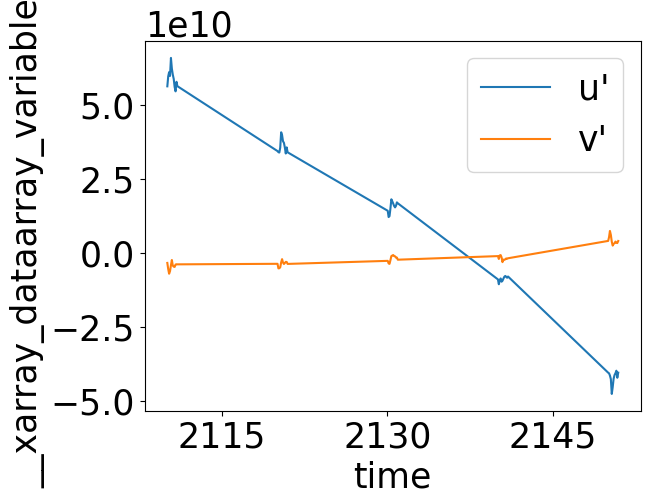

In [78]:
u_transient_int_merged.__xarray_dataarray_variable__  .plot(label = 'u\'')
v_transient_int_merged.__xarray_dataarray_variable__  .plot(label = 'v\'')
plt.legend()

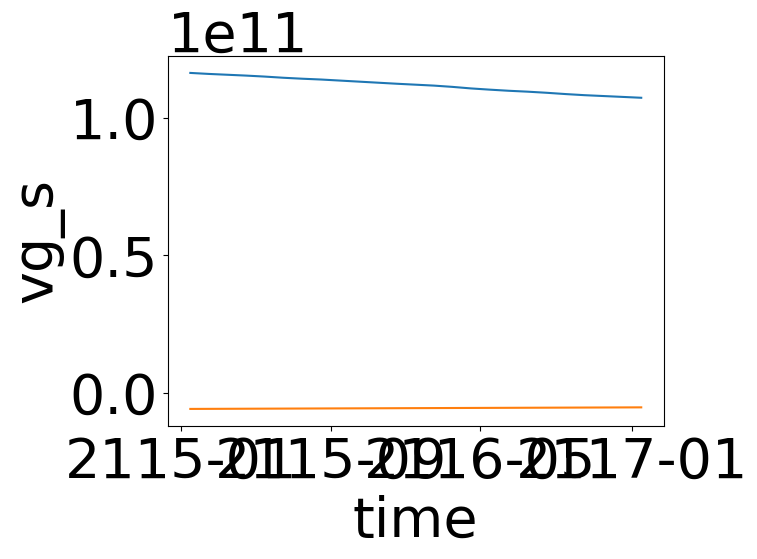

In [32]:
u_transient_int_merged.ug_s.rolling(time = 120, center = True).mean().plot()
v_transient_int_merged.vg_s.rolling(time = 120, center = True).mean().plot()